# Datasets & DataLoaders

- `Dataset`: stores samples and corresponding labels
- `DataLoader`: wraps an iterable around the `Dataset` to enable easy access to samples

Here, we'll use the `FashionMNIST` dataset per the online tutorial. Note that I was looking into a text example but `torchtext` development has [stopped](https://github.com/pytorch/text/issues/2250).



In [ ]:
import os

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

# Loading a Dataset

Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

- `root`: the path where the train/test data is stored
- `train`: specifies training or test dataset
- `download=True`: downloads the data if it's not available at root
- `transform` and `target_trasnsform` specify feature and label transformations


In [3]:
%load_ext watermark

In [ ]:
DATA_DIR="../local_data/transformer-mentor_data"

training_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.78MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.37MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.2MB/s]


# Iterating and Visualizing the Dataset

In [49]:
type(training_data)

torchvision.datasets.mnist.FashionMNIST

In [38]:
# first training set example, first element of tuple is a tensor
training_data[0][0].shape


torch.Size([1, 28, 28])

In [ ]:
# first training set example, second element of tuple is the label (int)
training_data[0][1]

9

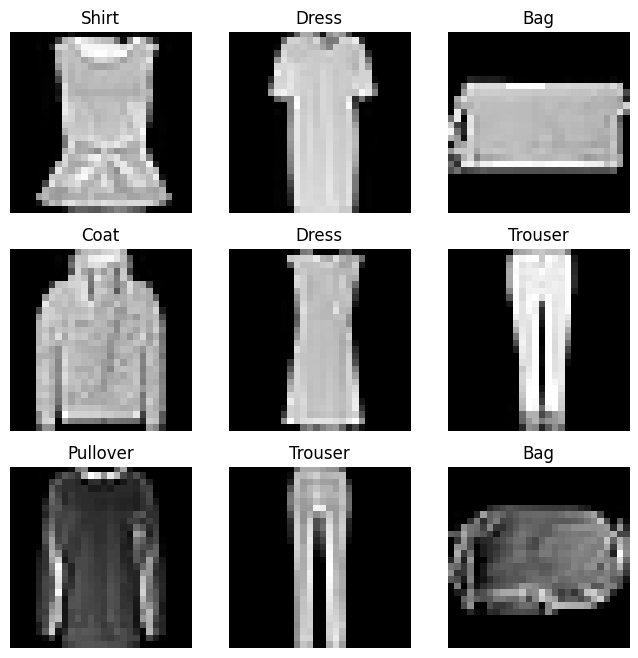

In [9]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# verify saving of data with `download=True`

if os.path.exists(DATA_DIR):
    print("Data directory contents:", os.listdir(DATA_DIR))
    if os.path.exists('data/FashionMNIST'):
        print("FashionMNIST contents:", os.listdir(os.path.join(DATA_DIR, 'FashionMNIST')))
else:
    print("Data directory not found!")

Data directory contents: ['FashionMNIST']
FashionMNIST contents: ['raw']


In [ ]:
# `size=(1,)` makes it so that it is only one []
torch.randint(len(training_data), size=(1,))

tensor([34250])

In [41]:
# .item() makes it a regular python int
torch.randint(len(training_data), size=(1,)).item()

22612

# Creating a Custom Dataset for your files

Three functions required for the class:
- `__init__`
- `__len__`
- `__getitem__`

In [ ]:
import os
import pandas as pd
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file: str, img_dir: str, transform=None, target_transform=None):
        """Instantiate the Dataset object.
        Initialize the directory containing images, the annotation file, and transforms.

        `labels.csv` file looks like this:
        tshirt1.jpg, 0
        tshirt2.jpg, 0
        ......
        ankleboot999.jpg, 9

        See here for possible `transform` optionss: https://docs.pytorch.org/vision/0.9/transforms.html
        Possible `target_transform` include string to label (e.g. {'cat': 0, 'dog': 1, 'bird': 2},
            or one-hot encoding
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.img_labels)

    def __getitem__(self, idx: int) -> tuple:
        """Load and return a sample at the given `idx`."""

        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)  # converts to a tensor
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Preparing your data for training with DataLoaders

`Dataset` retrieves features and labels one sample at a time. During training, obtaining samples in "minibatches", reshuffling to reduce overfitting, and using Python `multiprocessing` to speed up retrieval is facilitated by `DataLoader`.

In [1]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

NameError: name 'training_data' is not defined

# Iterate through the DataLoader

After loading into `DataLoader` we can iterate through the dataset as needed. Each iteration returns a batch of training samples (`train_features` and corresponding `train_labels`). We specified `batch_size=64` above so therefore there will be 64 samples in each, and each batch will be shuffled.

NOTE: The optimal batch size is determined through a combination of hardware constraints, training dynamics, and empirical testing.
```
# Start with the largest batch size your GPU can handle
# Common approach: double batch size until you get OOM error, then use ~75% of max
batch_sizes_to_try = [32, 64, 128, 256, 512, 1024]
```

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])

Show first example from a batch:


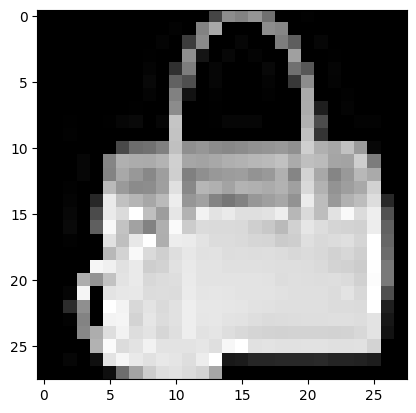

Label: 8


In [67]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(f"\nShow first example from a batch:")
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [68]:
# Labels from a batch
train_labels

tensor([8, 1, 9, 0, 1, 6, 6, 2, 2, 2, 2, 2, 6, 3, 2, 5, 7, 4, 2, 9, 3, 0, 7, 7,
        4, 5, 6, 3, 8, 3, 4, 6, 9, 8, 5, 0, 6, 2, 7, 7, 9, 9, 7, 0, 5, 4, 1, 3,
        2, 5, 9, 5, 8, 1, 2, 1, 5, 3, 2, 1, 6, 3, 4, 1])

In [ ]:
# verify saving of data with `download=True`

if os.path.exists(DATA_DIR):
    print("Data directory contents:", os.listdir(DATA_DIR))
    if os.path.exists('data/FashionMNIST'):
        print("FashionMNIST contents:", os.listdir(os.path.join(DATA_DIR, 'FashionMNIST')))
else:
    print("Data directory not found!")

Data directory contents: ['FashionMNIST']
FashionMNIST contents: ['raw']


In [4]:
%watermark

Last updated: 2025-08-10T00:17:39.302246+00:00

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.10.14-linuxkit
Machine     : aarch64
Processor   : 
CPU cores   : 7
Architecture: 64bit



In [5]:
%watermark -iv

torch      : 2.7.1
torchvision: 0.22.1
matplotlib : 3.10.3

